In [82]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import signal
#import xesmf as xe
from scipy.ndimage import gaussian_filter
from scipy.stats.stats import pearsonr


In [2]:
#define function to get all the data at once, use same years for climatology for all data
def get_data():
    
    #climatology years
#    cyr1,cyr2='1993-01-01','2019-12-31'
    cyr1,cyr2='2010-01-01','2019-12-31'
    
    # CCMP test
    dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    ds = ds.sel(time=slice(cyr1,cyr2))
    ds_ccmp = ds.drop('nobs')
    # MAKE DAY AVERAGE
    ds_ccmp = ds_ccmp.resample(time='D').mean()
    for var in ds_ccmp:
        tem = ds_ccmp[var].attrs
        tem['var_name']='ccmp_'+str(var)
        ds_ccmp[var].attrs=tem
    ds_ccmp_clim = ds_ccmp.sel(time=slice(cyr1,cyr2))
    ds_ccmp_clim = ds_ccmp_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    #sst
    dir_pattern_zarr = 'F:/data/sst/cmc/zarr/'
    ds_sst= xr.open_zarr(dir_pattern_zarr)
    ds_sst = ds_sst.drop({'analysis_error','mask','sea_ice_fraction'})
    ds_sst = ds_sst.sel(time=slice(cyr1,cyr2))
    tem = ds_sst.analysed_sst.attrs
    tem['var_name']='cmc_sst'
    ds_sst.analysed_sst.attrs=tem
    ds_sst_clim = ds_sst.sel(time=slice(cyr1,cyr2))
    ds_sst_clim = ds_sst_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    #put data into a dictionary
    data_dict={'wnd':ds_ccmp,
               'sst':ds_sst}
    clim_dict={'wnd_clim':ds_ccmp_clim,
               'sst_clim':ds_sst_clim}
  
    return data_dict,clim_dict


def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    function from: https://climate-cms.org/2019/07/29/multi-apply-along-axis.html
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    import numpy
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = numpy.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = numpy.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return numpy.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)


In [3]:
data,clim=get_data()

In [4]:
data['sst']

<xarray.Dataset>
Dimensions:       (lat: 901, lon: 1800, time: 730)
Coordinates:
  * lat           (lat) float32 -90.0 -89.8 -89.6 -89.4 ... 89.4 89.6 89.8 90.0
  * lon           (lon) float32 -180.0 -179.8 -179.6 ... 179.4 179.6 179.8
  * time          (time) datetime64[ns] 2018-01-01T12:00:00 ... 2019-12-31T12:00:00
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(381, 300, 300), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.4
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              Bruce.Brasnett@ec.gc.ca
    creator_name:               Bruce Brasnett, Environment Canada
    creator_url:                http://www.ec.gc.ca/scitech/default.asp?lang=...
    date_created:               20131002T175853Z
    easternmost_longitude:      179.8000030517578
    file_quality_level:         3
    gds_version_id:             02.5
    geospatial_lat_resolution:  0.20000000298023224
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.20000000298023224
    geospatial_lon_units:       degrees_east
    history:                    Processed through sfc.thin_sst, sfc.sstobs, i...
    id:                         CMC0.2deg-CMC-L4-GLOB-v2.0
    institution:                CMC
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    license:                    GHRSST protocol describes data use as free an...
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    naming_authority:           org.ghrsst
    netcdf_version_id:          4.3.0
    northernmost_latitude:      90.0
    platform:                   ERS-1
    processing_level:           L4
    product_version:            2.0
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_email:            ghrsst-po@nceo.ac.uk
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    references:                 Brasnett B. 2008. The impact of satellite ret...
    sensor:                     ATSR
    source:                     EUR-L2P-ATS_NR_2P,IN_SITU-ICOADS_BUOYS,IN_SIT...
    southernmost_latitude:      -90.0
    spatial_resolution:         0.2 degree
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    start_time:                 19910901T000000Z
    stop_time:                  19910902T000000Z
    summary:                    Applies the method of statistical interpolati...
    time_coverage_end:          19910902T000000Z
    time_coverage_start:        19910901T000000Z
    title:                      CMC 0.2 deg global sea surface temperature an...
    uuid:                       67270ff2-25d7-4390-8bc1-fee0a6209243
    westernmost_longitude:      -180.0

In [5]:
data['wnd']

,Array,Chunk
Bytes,2.64 GB,113.04 kB
Shape,"(730, 628, 1440)","(1, 157, 180)"
Count,120001 Tasks,23360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.64 GB,113.04 kB
Shape,"(730, 628, 1440)","(1, 157, 180)"
Count,120001 Tasks,23360 Chunks
Type,float32,numpy.ndarray


In [6]:
ds_sst, ds_wnd = data['sst'],data['wnd']
ds_wnd['wspd']=(ds_wnd.uwnd**2+ds_wnd.vwnd**2)**.5
#interp doesn't work on chunked dims so rechunk
ds_sst = ds_sst.chunk({'time':1,'lat':901,'lon':1800})
ds_new = ds_sst.interp(lat = ds_wnd.lat,lon=ds_wnd.lon)

In [7]:
#SST
#remove mean, seasonal cycle, trend before analysis
clim = ds_new.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
ds_new_tem = ds_new.groupby('time.dayofyear')-clim
#detrending doesn't work with nan so fill with nan but will have to mask at end and pixels with nan in timeseries
tem = ds_new_tem.fillna(0)
ds_detrended_sst = signal.detrend(tem.analysed_sst,axis=0)

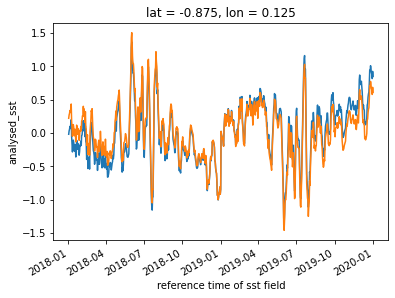

In [8]:
ds_new_tem.analysed_sst.isel(lon=720,lat=310).plot()
plt.plot(ds_new_tem.time,ds_detrended_sst[:,310,720])

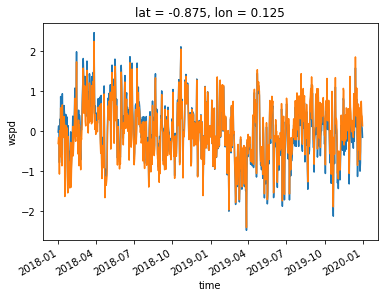

In [9]:
#WSPD
#remove mean, seasonal cycle, trend before analysis
clim = ds_wnd.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
ds_new_tem = ds_wnd.groupby('time.dayofyear')-clim
#detrending doesn't work with nan so fill with nan but will have to mask at end and pixels with nan in timeseries
tem = ds_new_tem.fillna(0)
ds_detrended_wnd = signal.detrend(tem.wspd,axis=0)
ds_new_tem.wspd.isel(lon=720,lat=310).plot()
plt.plot(ds_new_tem.time,ds_detrended_wnd[:,310,720])

In [59]:
corr = multi_apply_along_axis(pearsonr, 0, [ds_detrended_sst,ds_detrended_wnd])
print(corr.shape)
print(type(corr))
#not sure why by 1440 is blank
acorr = corr[0,:,:]
acorr2 = np.concatenate([acorr[:,720:1439],acorr[:,:1439],acorr[:,:720]],axis=1)
#plt.imshow(acorr[:,:1439],vmin=-.1,vmax=.1,cmap='RdBu')
#plt.imshow(acorr2,vmin=-.1,vmax=.1,cmap='viridis')
data = acorr2
data = np.nan_to_num(data,0)
lowpass = ndimage.gaussian_filter(data, 40)
gauss_highpass = data - lowpass




C:\Users\gentemann\Miniconda3\envs\sstenv\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(2, 628, 1440)
<class 'numpy.ndarray'>


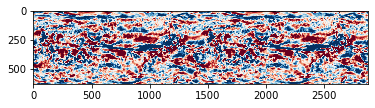

In [81]:
plt.imshow(lowpass,vmin=-.1,vmax=.1,cmap='RdBu')
plt.imshow(gauss_highpass,vmin=-.1,vmax=.1,cmap='RdBu')